In [425]:
import pandas as pd
from sklearn.metrics import roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

sns.set_theme()
%matplotlib inline

In [429]:
json_results_file = '../predictions/multiple_imputation_median_pooling.json'

predictions = None
with open(json_results_file, 'r') as file:
    data_json = json.load(file)
    for model_full_name, df_data in data_json.items():
        model_short_name = model_full_name.split('_')[0]
        predictions = pd.DataFrame(df_data)
        break

predictions.head()

,y_test,binary_predictions,probabilities,patient_id
0,0,0,0.151226,25312
1,0,1,0.633058,59342
2,0,0,0.007471,50777
3,0,0,0.049166,46918
4,0,0,0.012339,34377


In [428]:
data_file = '../data/training_v2.csv'
data = pd.read_csv(data_file)
data.head()

,encounter_id,patient_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis,apache_3j_bodysystem,apache_2_bodysystem
0,66154,25312,118,0,68.0,22.73,0,Caucasian,M,180.3,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Sepsis,Cardiovascular
1,114252,59342,81,0,77.0,27.42,0,Caucasian,F,160.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,Respiratory,Respiratory
2,119783,50777,118,0,25.0,31.95,0,Caucasian,F,172.7,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Metabolic,Metabolic
3,79267,46918,118,0,81.0,22.64,1,Caucasian,F,165.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cardiovascular,Cardiovascular
4,92056,34377,33,0,19.0,NaN,0,Caucasian,M,188.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Trauma,Trauma


In [430]:
predictions = predictions.join(data, on='patient_id', rsuffix='_data', how='left')[['y_test', 'probabilities', 'age', 'ethnicity', 'gender']]
predictions = predictions.rename(columns={'y_test': 'labels', 'probabilities': 'predictions'})
predictions.head()

,labels,predictions,age,ethnicity,gender
0,0,0.151226,57.0,African American,F
1,0,0.633058,48.0,Caucasian,M
2,0,0.007471,34.0,Caucasian,F
3,0,0.049166,60.0,Caucasian,F
4,0,0.012339,80.0,Caucasian,F


In [431]:
data = pd.read_csv("XGBClassifier_predictions.csv")

In [457]:
def plot_roc_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    auc_score = np.round(auc(fpr, tpr), 3)
    plt.plot(fpr, tpr, label=f'{label} (AUROC={auc_score})')

  # Add subtle y=x line
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--', alpha=0.5)

  # Customize plot and display
  plt.xlabel("1 - Specificity (False Positive Rate)")
  plt.ylabel("Sensitivity (True Positive Rate)")
  # plt.title(f"ROC Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

In [458]:
def plot_precision_recall_curves(df, column_name, label_col="labels", pred_col="predictions", value_names={}):
  unique_values = sorted(df[column_name].unique())

  plt.figure(figsize=(10, 6))
  for i, value in enumerate(unique_values):
    group_data = df[df[column_name] == value]
    y_true = group_data[label_col]
    y_pred = group_data[pred_col]
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    label = value_names.get(value, value)  # Use custom label if available
    auc_score = np.round(auc(recall, precision), 3)
    plt.plot(recall, precision, label=f'{label} (PRAUC={auc_score})')

  # Customize plot and display
  plt.xlabel("Recall (Sensitivity)")
  plt.ylabel("Precision (Positive Predictive Value)")
  # plt.title(f"Precision-Recall Curves by {column_name}")
  plt.legend(title=column_name)
  plt.grid(True)
  plt.show()

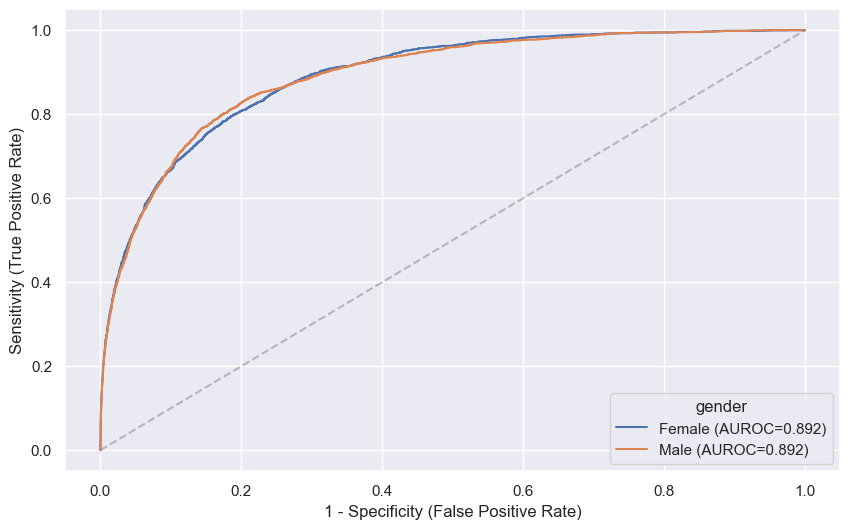

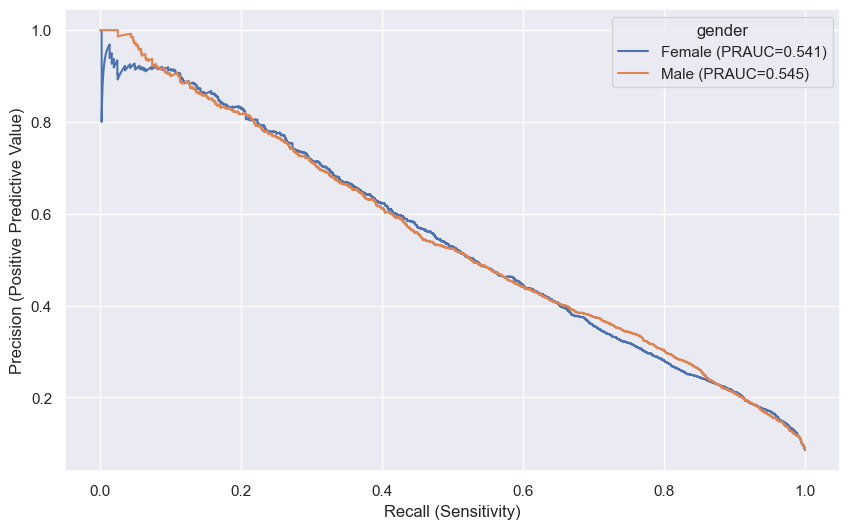

In [459]:
gender_labels = {
  'F': 'Female',
  'M': 'Male'
}

data_gender_drop_na = pd.DataFrame(predictions)
data_gender_drop_na.dropna(inplace=True)

plot_roc_curves(data_gender_drop_na, 'gender', value_names=gender_labels)
plot_precision_recall_curves(data_gender_drop_na, 'gender', value_names=gender_labels)

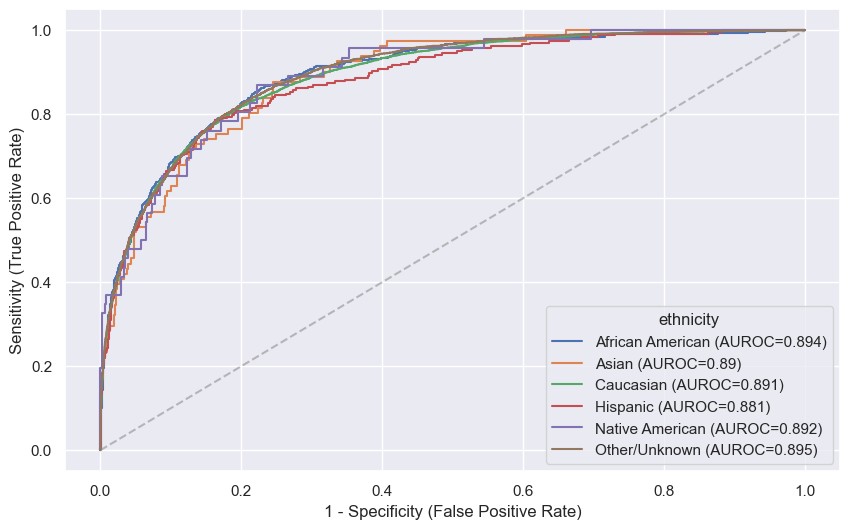

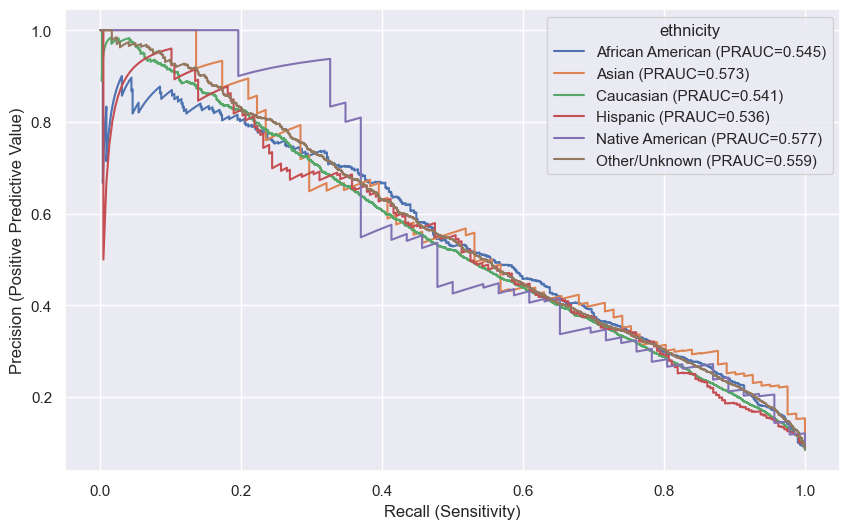

In [460]:
predictions['ethnicity'] = predictions['ethnicity'].fillna('Other/Unknown')
plot_roc_curves(predictions, 'ethnicity')
plot_precision_recall_curves(predictions, 'ethnicity')

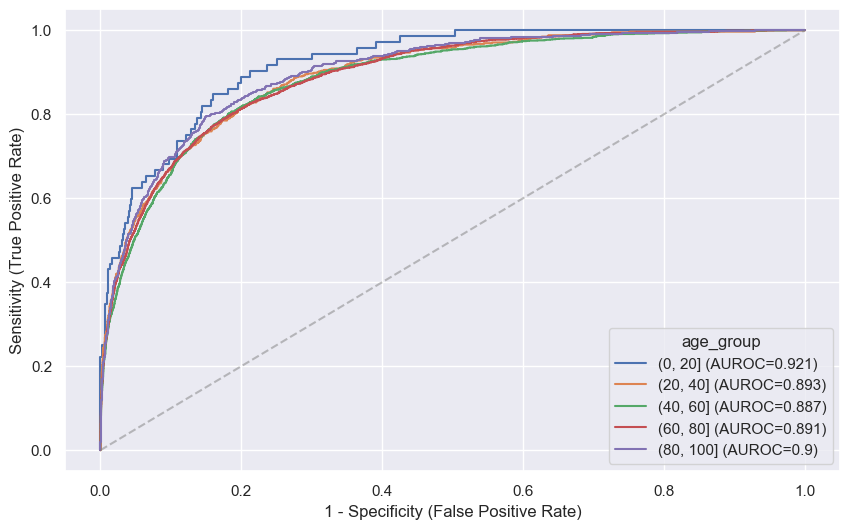

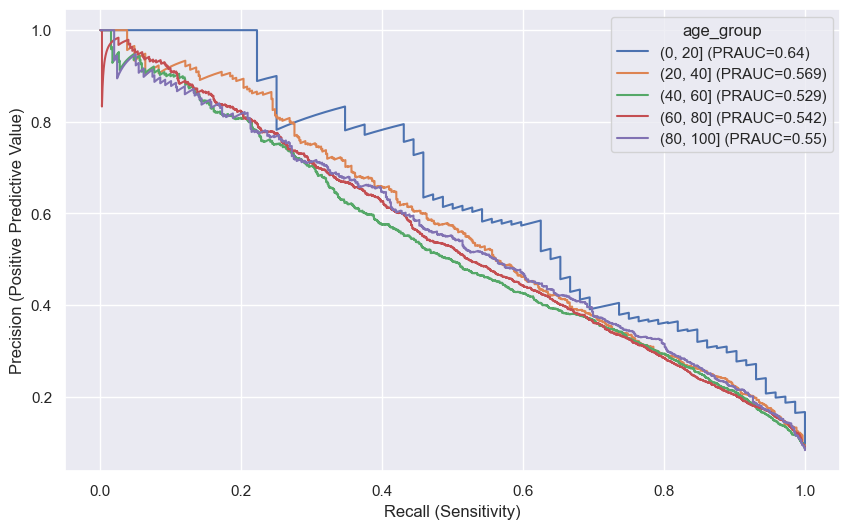

In [461]:
# Define age groups with 20-year steps
age_groups = range(0, 101, 20)
age_groups_labels = [pd.Interval(left=b, right=b+20) for b in range(0, 101, 20)]

# Use pd.cut to create the age group column based on boundaries and labels
data_with_age_groups = predictions.copy()

# data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups[:-1])
data_with_age_groups['age_group'] = pd.cut(data_with_age_groups['age'], age_groups, labels=age_groups_labels[:-1])
data_with_age_groups.dropna(inplace=True)

plot_roc_curves(data_with_age_groups, 'age_group')
plot_precision_recall_curves(data_with_age_groups, 'age_group')

In [344]:
data_with_age_groups.to_csv('XGBClassifier_predictions_with_protected_groups.csv')

In [404]:
sorted_data_by_pred = data_with_age_groups.sort_values('predictions', ascending=False)
top_pred_dict = {
    'Top 10': sorted_data_by_pred.head(10),
    'Top 30': sorted_data_by_pred.head(30),
    'Top 50': sorted_data_by_pred.head(50),
    'Top 100': sorted_data_by_pred.head(100),
}

groups_for_top_pred = {
    'gender': [gender for gender in data_with_age_groups['gender'].unique().tolist()],
    'ethnicity': [gender for gender in data_with_age_groups['ethnicity'].unique().tolist()],
}

# print(json.dumps(groups_for_top_pred, indent=4))

top_pred_df = pd.DataFrame(columns=[key for key in top_pred_dict.keys()])

for top_index in top_pred_dict.keys():
    for group in groups_for_top_pred.keys():
        subgroups_percentages = top_pred_dict[top_index][group].value_counts()
        for subgroup in groups_for_top_pred[group]:
            if subgroup in subgroups_percentages.index:
                print(f'{top_index} - {subgroup}: {subgroups_percentages[subgroup]}')
                top_pred_df.loc[subgroup, top_index] = np.round(subgroups_percentages[subgroup] * 100 / top_pred_dict[top_index].shape[0], 2)
            else:
                print(f'{top_index} - {subgroup}: 0')
                top_pred_df.loc[subgroup, top_index] = 0
top_pred_df

Top 10 - F: 4
Top 10 - M: 6
Top 10 - African American: 0
Top 10 - Caucasian: 8
Top 10 - Other/Unknown: 0
Top 10 - Hispanic: 0
Top 10 - Asian: 2
Top 10 - Native American: 0
Top 30 - F: 15
Top 30 - M: 15
Top 30 - African American: 1
Top 30 - Caucasian: 26
Top 30 - Other/Unknown: 1
Top 30 - Hispanic: 0
Top 30 - Asian: 2
Top 30 - Native American: 0
Top 50 - F: 22
Top 50 - M: 28
Top 50 - African American: 1
Top 50 - Caucasian: 43
Top 50 - Other/Unknown: 4
Top 50 - Hispanic: 0
Top 50 - Asian: 2
Top 50 - Native American: 0
Top 100 - F: 46
Top 100 - M: 54
Top 100 - African American: 3
Top 100 - Caucasian: 84
Top 100 - Other/Unknown: 8
Top 100 - Hispanic: 0
Top 100 - Asian: 5
Top 100 - Native American: 0


,Top 10,Top 30,Top 50,Top 100
F,40.0,50.0,44.0,46.0
M,60.0,50.0,56.0,54.0
African American,0,3.33,2.0,3.0
Caucasian,80.0,86.67,86.0,84.0
Other/Unknown,0,3.33,8.0,8.0
Hispanic,0,0,0,0
Asian,20.0,6.67,4.0,5.0
Native American,0,0,0,0


## Multi-Calibration

In [468]:
def calculate_calibration_in_the_large(subgroup_df: pd.DataFrame, predictions_column_name, subgroup_nudges_dict):
    """Calculates the odds ratio for a given subgroup using your formula.

    Args:
        subgroup_df (pd.DataFrame): A DataFrame containing data for a specific subgroup.

    Returns:
        float: The odds ratio for the subgroup using your formula.
    """

    nudge = 0
    if subgroup_nudges_dict is not None:
        subgroup_group_by = subgroup_df.groupby(['age_group', 'gender', 'ethnicity']).count().reset_index()
        _, group = next(subgroup_group_by.iterrows())
        subgroup_id = str(group.values[:3])
        nudge = subgroup_nudges_dict[subgroup_id]['nudge']
        print(f'subgroup: {subgroup_id}, nudge: {nudge}')
    
    avg_prediction = (subgroup_df[predictions_column_name] + nudge).mean()
    avg_outcome = subgroup_df["labels"].mean()

    if avg_prediction == 1 or avg_outcome == 0 or avg_outcome == 1:
        # Handle cases where division by zero would occur
        return None

    # Calculate odds ratio using your formula
    calibration_in_the_large = (avg_prediction / (1 - avg_prediction)) / (avg_outcome / (1 - avg_outcome))

    return np.round(calibration_in_the_large, 3)

In [483]:
data_with_age_groups['calibrated_predictions'] = data_with_age_groups['predictions']
subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])
# subgroups_calibration_groups_by = subgroups_group_by.sample(frac=.2, random_state=2)
subgroups_calibration_groups_by = data_with_age_groups
subgroups_validation_groups_by = data_with_age_groups[~data_with_age_groups.index.isin(subgroups_calibration_groups_by.index.to_list())]
subgroups_df = subgroups_group_by.count().reset_index()

protected_groups_dict = { str(subgroup.values[:3]): {'nudge': 0} for index, subgroup in subgroups_df.iterrows()}
protected_groups_dict

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/1948605860.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_group_by = data_with_age_groups.groupby(['age_group', 'gender', 'ethnicity'])


{"[Interval(0, 20, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'African American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Asian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Hispanic']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Native American']": {'nudge': 0},
 "[Interval(0, 20, closed='right') 'M' 'Other/Unknown']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'African American']": {'nudge': 0},
 "[Interval(20, 40, closed='right') 'F' 'Asian']": {'nudge': 0},
 "[Interval(20, 40,

In [484]:
alpha = 0.0005
done = False
while not done:
    done = True
    for group_index, subgroup in subgroups_df.iterrows():
        subgroup_df = subgroups_calibration_groups_by.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']),]
        subgroup_id = str(subgroup.values[:3])
        sum_y = subgroup_df['labels'].sum()
        sum_p = (subgroup_df['predictions'] + protected_groups_dict[subgroup_id]['nudge']).sum()
        violation = (sum_y - sum_p) / subgroup_df.shape[0]
        print(f'subgroup: {subgroup_id}, violation: {violation} (sum_y = {sum_y}, sum_p = {sum_p}), count: {subgroup_df.shape[0]}')
        if np.abs(violation) > alpha:
            protected_groups_dict[subgroup_id]['nudge'] += violation * 0.1
            subgroups_calibration_groups_by.loc[(data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity']), 'calibrated_predictions'] += violation * 0.1
            done = False

subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], violation: 0.048527393835566694 (sum_y = 10, sum_p = 6.991301582194865), count: 62
subgroup: [Interval(0, 20, closed='right') 'F' 'Asian'], violation: -0.07287176698446274 (sum_y = 0, sum_p = 0.43723060190677643), count: 6
subgroup: [Interval(0, 20, closed='right') 'F' 'Caucasian'], violation: 0.012650648154724473 (sum_y = 26, sum_p = 22.63492759084329), count: 266
subgroup: [Interval(0, 20, closed='right') 'F' 'Hispanic'], violation: -0.0163075774360229 (sum_y = 1, sum_p = 1.2772288164123893), count: 17
subgroup: [Interval(0, 20, closed='right') 'F' 'Native American'], violation: -0.03744132025167346 (sum_y = 0, sum_p = 0.486737163271755), count: 13
subgroup: [Interval(0, 20, closed='right') 'F' 'Other/Unknown'], violation: -0.02633256249985582 (sum_y = 2, sum_p = 2.9743048124946654), count: 37
subgroup: [Interval(0, 20, closed='right') 'M' 'African American'], violation: -0.0021366931840169187 (sum_y = 6, sum_p = 6.1

In [485]:
# subgroups_after_calibration_df = subgroups_validation_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
subgroups_after_calibration_df = subgroups_calibration_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
calibration_in_the_large = pd.DataFrame()
# calibration_in_the_large['before_calibration'] = np.log10(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None)))
# calibration_in_the_large['after_calibration'] = np.log10(subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions', protected_groups_dict)))
calibration_in_the_large['before_calibration'] = subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None))
calibration_in_the_large['after_calibration'] = subgroups_after_calibration_df.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions', protected_groups_dict))
calibration_in_the_large.dropna(inplace=True)

subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883
subgroup: [Interval(0, 20, closed='right') 'F' 'Asian'], nudge: -0.07240810685360084
subgroup: [Interval(0, 20, closed='right') 'F' 'Caucasian'], nudge: 0.012168000089334578
subgroup: [Interval(0, 20, closed='right') 'F' 'Hispanic'], nudge: -0.01585401741122196
subgroup: [Interval(0, 20, closed='right') 'F' 'Native American'], nudge: -0.03694324605704199
subgroup: [Interval(0, 20, closed='right') 'F' 'Other/Unknown'], nudge: -0.025852045803734364
subgroup: [Interval(0, 20, closed='right') 'M' 'African American'], nudge: -0.0016478863189100656
subgroup: [Interval(0, 20, closed='right') 'M' 'Asian'], nudge: -0.0727740624458651
subgroup: [Interval(0, 20, closed='right') 'M' 'Caucasian'], nudge: -0.006552312823872177
subgroup: [Interval(0, 20, closed='right') 'M' 'Hispanic'], nudge: 0.06707967964387611
subgroup: [Interval(0, 20, closed='right') 'M' 'Native American'], nudge: -0.002491111082151665

/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2901424318.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_after_calibration_df = subgroups_calibration_groups_by.groupby(['age_group', 'gender', 'ethnicity'])
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2469191887.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroup_group_by = subgroup_df.groupby(['age_group', 'gender', 'ethnicity']).count().reset_index()
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2469191887.py:13: FutureWarning: The default of observed=False is deprecated and wi

In [472]:
calculate_calibration_in_the_large(subgroups_calibration_groups_by, 'predictions', None)

0.945

In [489]:
subgroups_group_by_age_group = subgroups_calibration_groups_by.groupby(['age_group'])
age_group_calibration_in_the_large = pd.DataFrame()
age_group_calibration_in_the_large['calibration_in_the_large_before'] = subgroups_group_by_age_group.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None))
age_group_calibration_in_the_large['calibration_in_the_large_after'] = subgroups_group_by_age_group.apply(lambda df: calculate_calibration_in_the_large(df, 'calibrated_predictions', protected_groups_dict))
age_group_calibration_in_the_large.dropna(inplace=True)
age_group_calibration_in_the_large

subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883
subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883
subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883
subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883
subgroup: [Interval(0, 20, closed='right') 'F' 'African American'], nudge: 0.04805678791839883


/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/552158610.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroups_group_by_age_group = subgroups_calibration_groups_by.groupby(['age_group'])
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2469191887.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  subgroup_group_by = subgroup_df.groupby(['age_group', 'gender', 'ethnicity']).count().reset_index()
/var/folders/m7/g2p4ht5n18x83ks3g6mbtjg40000gn/T/ipykernel_32186/2469191887.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a

,calibration_in_the_large_before,calibration_in_the_large_after
age_group,,
"(0, 20]",0.947,1.612
"(20, 40]",0.893,1.617
"(40, 60]",0.942,1.639
"(60, 80]",0.945,1.647
"(80, 100]",0.993,1.666


In [470]:
subgroups_group_by_gender = subgroups_calibration_groups_by.groupby(['gender'])
gender_calibration_in_the_large = pd.DataFrame()
gender_calibration_in_the_large['calibration_in_the_large'] = subgroups_group_by_gender.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None))
gender_calibration_in_the_large.dropna(inplace=True)
gender_calibration_in_the_large

,calibration_in_the_large
gender,
F,0.946
M,0.944


In [471]:
subgroups_group_by_ethnicity = subgroups_calibration_groups_by.groupby(['ethnicity'])
ethnicity_calibration_in_the_large = pd.DataFrame()
ethnicity_calibration_in_the_large['calibration_in_the_large'] = subgroups_group_by_ethnicity.apply(lambda df: calculate_calibration_in_the_large(df, 'predictions', None))
ethnicity_calibration_in_the_large.dropna(inplace=True)
ethnicity_calibration_in_the_large

,calibration_in_the_large
ethnicity,
African American,0.895
Asian,0.905
Caucasian,0.954
Hispanic,0.876
Native American,1.022
Other/Unknown,0.965


In [383]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_predictions_df = pd.DataFrame(subgroups_calibration_groups_by)
calibrated_predictions_df['calibrated_predictions'] = calibrated_predictions_df['predictions']

# Assuming your dataframe with all data is called 'df'
for index, subgroup in subgroups_df.iterrows():
  group_index = (data_with_age_groups['age_group'] == subgroup['age_group']) & (data_with_age_groups['gender'] == subgroup['gender']) & (data_with_age_groups['ethnicity'] == subgroup['ethnicity'])
  subgroup_df = calibrated_predictions_df.loc[group_index,]
  # Extract data for the current protected group
  # X_group = subgroup_df[['predictions']]
  # y_group = subgroup_df['labels']

  # # Calibrate the predictions using Platt scaling
  # calibrator = CalibratedClassifierCV(n_jobs=-1, cv=5, )  # Adjust n_jobs and cv as needed
  # calibrator.fit(X_group, y_group)
  # calibrated_predictions = calibrator.predict_proba(X_group)[:, 1]

  predictions = subgroup_df['predictions']
  labels = subgroup_df['labels']

  # Sort predictions and labels together
  data = np.vstack([predictions, labels]).T
  data = data[data[:, 0].argsort()]  # Sort by prediction

  # Calculate quantiles of true labels based on sorted predictions
  calibrated_predictions = np.percentile(data[:, 1], np.interp(predictions, data[:, 0], range(100))) / 100

  # Update the original dataframe (assuming the index matches)
  calibrated_predictions_df.loc[group_index, 'calibrated_predictions'] = calibrated_predictions

ValueError: fp and xp are not of the same length.

Max calibration: subpopulation - (Interval(20, 40, closed='right'), 'F', 'Native American'), value: 5.785, index: 13
Min calibration: subpopulation - (Interval(80, 100, closed='right'), 'M', 'Native American'), value: 0.401, index: 55


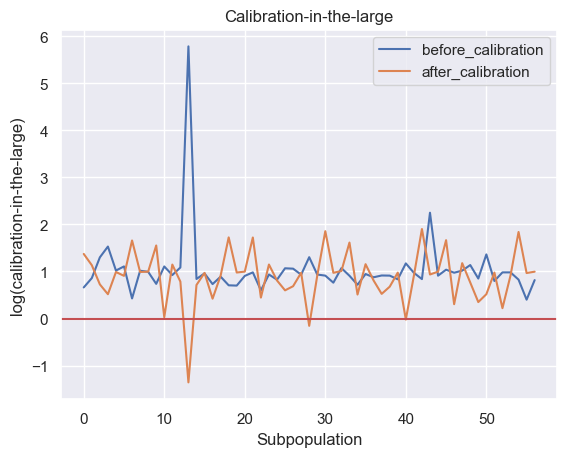

In [486]:
calibration_in_the_large.reset_index().plot(title='Calibration-in-the-large', ylabel='log(calibration-in-the-large)', xlabel='Subpopulation')
plt.axhline(y=0, color='r')

max_subgroup_before_index = calibration_in_the_large['before_calibration'].argmax()
max_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[max_subgroup_before_index], 'before_calibration']
max_subgroup_before_name = calibration_in_the_large.index[max_subgroup_before_index]
print(f'Max calibration: subpopulation - {max_subgroup_before_name}, value: {max_subgroup_before_value}, index: {max_subgroup_before_index}')

min_subgroup_before_index = calibration_in_the_large['before_calibration'].argmin()
min_subgroup_before_value = calibration_in_the_large.loc[calibration_in_the_large.index[min_subgroup_before_index], 'before_calibration']
min_subgroup_before_name = calibration_in_the_large.index[min_subgroup_before_index]
print(f'Min calibration: subpopulation - {min_subgroup_before_name}, value: {min_subgroup_before_value}, index: {min_subgroup_before_index}')

In [462]:
sorted_data_by_calibrated_pred = subgroups_calibration_groups_by.sort_values('calibrated_predictions', ascending=False)
top_calibrated_pred_dict = {
    'Top 10': sorted_data_by_calibrated_pred.head(10),
    'Top 30': sorted_data_by_calibrated_pred.head(30),
    'Top 50': sorted_data_by_calibrated_pred.head(50),
    'Top 100': sorted_data_by_calibrated_pred.head(100),
}

groups_for_top_calibrated_pred = {
    'gender': [gender for gender in subgroups_calibration_groups_by['gender'].unique().tolist()],
    'ethnicity': [gender for gender in subgroups_calibration_groups_by['ethnicity'].unique().tolist()],
    'age_group': [gender for gender in subgroups_calibration_groups_by['age_group'].unique().tolist()],
}

# print(json.dumps(groups_for_top_calibrated_pred, indent=4))

top_calibrated_pred_df = pd.DataFrame(columns=[key for key in top_calibrated_pred_dict.keys()])

for top_index in top_calibrated_pred_dict.keys():
    for group in groups_for_top_calibrated_pred.keys():
        subgroups_percentages = top_calibrated_pred_dict[top_index][group].value_counts()
        for subgroup in groups_for_top_calibrated_pred[group]:
            if subgroup in subgroups_percentages.index:
                print(f'{top_index} - {subgroup}: {subgroups_percentages[subgroup]}')
                top_calibrated_pred_df.loc[subgroup, top_index] = np.round(subgroups_percentages[subgroup] * 100 / top_calibrated_pred_dict[top_index].shape[0], 2)
            else:
                print(f'{top_index} - {subgroup}: 0')
                top_calibrated_pred_df.loc[subgroup, top_index] = 0
top_calibrated_pred_df

Top 10 - F: 6
Top 10 - M: 4
Top 10 - African American: 1
Top 10 - Caucasian: 5
Top 10 - Other/Unknown: 0
Top 10 - Hispanic: 0
Top 10 - Asian: 3
Top 10 - Native American: 1
Top 10 - (40, 60]: 1
Top 10 - (20, 40]: 2
Top 10 - (60, 80]: 6
Top 10 - (80, 100]: 1
Top 10 - (0, 20]: 0
Top 30 - F: 17
Top 30 - M: 13
Top 30 - African American: 1
Top 30 - Caucasian: 22
Top 30 - Other/Unknown: 2
Top 30 - Hispanic: 0
Top 30 - Asian: 4
Top 30 - Native American: 1
Top 30 - (40, 60]: 5
Top 30 - (20, 40]: 3
Top 30 - (60, 80]: 17
Top 30 - (80, 100]: 4
Top 30 - (0, 20]: 1
Top 50 - F: 22
Top 50 - M: 28
Top 50 - African American: 1
Top 50 - Caucasian: 41
Top 50 - Other/Unknown: 3
Top 50 - Hispanic: 0
Top 50 - Asian: 4
Top 50 - Native American: 1
Top 50 - (40, 60]: 12
Top 50 - (20, 40]: 5
Top 50 - (60, 80]: 24
Top 50 - (80, 100]: 8
Top 50 - (0, 20]: 1
Top 100 - F: 45
Top 100 - M: 55
Top 100 - African American: 2
Top 100 - Caucasian: 84
Top 100 - Other/Unknown: 7
Top 100 - Hispanic: 1
Top 100 - Asian: 5
Top 10

,Top 10,Top 30,Top 50,Top 100
F,60.0,56.67,44.0,45.0
M,40.0,43.33,56.0,55.0
African American,10.0,3.33,2.0,2.0
Caucasian,50.0,73.33,82.0,84.0
Other/Unknown,0,6.67,6.0,7.0
Hispanic,0,0,0,1.0
Asian,30.0,13.33,8.0,5.0
Native American,10.0,3.33,2.0,1.0
"(40, 60]",10.0,16.67,24.0,27.0
"(20, 40]",20.0,10.0,10.0,10.0


<Axes: title={'center': 'Clibration-in-the-large density'}, ylabel='Density'>

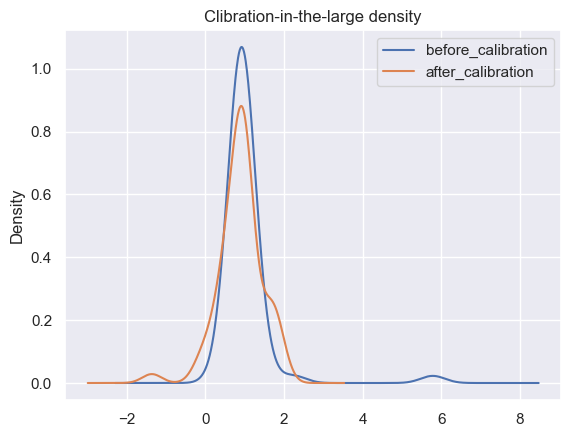

In [487]:
calibration_in_the_large.plot(kind='density', title='Clibration-in-the-large density')

In [139]:
print(json.dumps(protected_groups_dict, indent=4))

{
    "[Interval(0, 20, closed='right') 'F' 'African American']": {
        "nudge": 0.048527393835566694
    },
    "[Interval(0, 20, closed='right') 'F' 'Asian']": {
        "nudge": -0.07287176698446274
    },
    "[Interval(0, 20, closed='right') 'F' 'Caucasian']": {
        "nudge": 0.012650648154724473
    },
    "[Interval(0, 20, closed='right') 'F' 'Hispanic']": {
        "nudge": -0.0163075774360229
    },
    "[Interval(0, 20, closed='right') 'F' 'Native American']": {
        "nudge": -0.03744132025167346
    },
    "[Interval(0, 20, closed='right') 'F' 'Other/Unknown']": {
        "nudge": -0.02633256249985582
    },
    "[Interval(0, 20, closed='right') 'M' 'African American']": {
        "nudge": -0.0021366931840169187
    },
    "[Interval(0, 20, closed='right') 'M' 'Asian']": {
        "nudge": -0.07324006594717503
    },
    "[Interval(0, 20, closed='right') 'M' 'Caucasian']": {
        "nudge": -0.007004905504800263
    },
    "[Interval(0, 20, closed='right') 'M' 'Hi